<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# Chapter 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from urllib.request import urlretrieve
import zipfile

# Download and extra chapter 2 data zip files
url = 'https://assets.datacamp.com/production/repositories/3202/datasets/9c670a495912949de0166c3ce690bad536ccf621/chapter_2.zip'
file = 'chapter_2.zip'
urlretrieve(url, file)

zip_ref = zipfile.ZipFile(file, 'r')
zip_ref.extractall('./')
zip_ref.close()

## Recency, frequency, monetary
Classic variables to segment customers

In [2]:
from io import StringIO
data_str = ',CustomerID,Spend\n0,0,137\n1,1,335\n2,2,172\n3,3,355\n4,4,303\n5,5,233\n6,6,244\n7,7,229\n'
data = pd.read_csv(StringIO(data_str), index_col=0)
data

,CustomerID,Spend
0,0,137
1,1,335
2,2,172
3,3,355
4,4,303
5,5,233
6,6,244
7,7,229


In [3]:
# Create a spend quartile with 4 groups - a range between 1 and 5
spend_quartile = pd.qcut(data['Spend'], q=4, labels=range(1, 5))

# Assign the quartile values to the Spend_Quartile column in data
data['Spend_Quartile'] = spend_quartile

# Print data with sorted Spend values
print(data.sort_values('Spend'))

   CustomerID  Spend Spend_Quartile
0           0    137              1
2           2    172              1
7           7    229              2
5           5    233              2
6           6    244              3
4           4    303              3
1           1    335              4
3           3    355              4


In [4]:
from io import StringIO

data_str = ',CustomerID,Recency_Days\n0,0,37\n1,1,235\n2,2,396\n3,3,72\n4,4,255\n5,5,393\n6,6,203\n7,7,133\n'

data = pd.read_csv(StringIO(data_str), index_col=0)
data

,CustomerID,Recency_Days
0,0,37
1,1,235
2,2,396
3,3,72
4,4,255
5,5,393
6,6,203
7,7,133


In [5]:
# Store labels from 4 to 1 in a decreasing order
r_labels = list(range(4, 0, -1))

# Create a spend quartile with 4 groups and pass the previously created labels 
recency_quartiles = pd.qcut(data['Recency_Days'], q=4, labels=r_labels)

# Assign the quartile values to the Recency_Quartile column in `data`
data['Recency_Quartile'] = recency_quartiles 

# Print `data` with sorted Recency_Days values
print(data.sort_values('Recency_Days'))

   CustomerID  Recency_Days Recency_Quartile
0           0            37                4
3           3            72                4
7           7           133                3
6           6           203                3
1           1           235                2
4           4           255                2
5           5           393                1
2           2           396                1


RFM is typically measured to these scales:
* days since last transaction
* frequency number of transactions in last 12 months
* monetary value - sum of spend in last 12 monts

In [6]:
online = pd.read_csv('online12M.csv', index_col=0)
online['TotalSum'] = online['UnitPrice'] * online['Quantity']
online['InvoiceDate'] = pd.to_datetime(online['InvoiceDate'])
online.info(), online.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68176 entries, 416792 to 312243
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    68176 non-null  int64         
 1   StockCode    68176 non-null  object        
 2   Description  68176 non-null  object        
 3   Quantity     68176 non-null  int64         
 4   InvoiceDate  68176 non-null  datetime64[ns]
 5   UnitPrice    68176 non-null  float64       
 6   CustomerID   68176 non-null  int64         
 7   Country      68176 non-null  object        
 8   TotalSum     68176 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 5.2+ MB


(None,
            InvoiceNo      Quantity     UnitPrice    CustomerID      TotalSum
 count   68176.000000  68176.000000  68176.000000  68176.000000  68176.000000
 mean   561562.235904     11.556119      3.069209  15544.700100     19.808139
 std     12570.817828     41.133000     32.513232   1593.010549     76.936686
 min    538172.000000      1.000000      0.001000  12747.000000      0.001000
 25%    550512.000000      2.000000      1.250000  14189.000000      4.160000
 50%    562779.000000      4.000000      1.850000  15513.000000     10.200000
 75%    572650.000000     12.000000      3.750000  16930.000000     17.700000
 max    581586.000000   4300.000000   8142.750000  18287.000000   8142.750000)

In [7]:
snapshot_date = pd.to_datetime('2011-12-10 00:00:00')
snapshot_date

Timestamp('2011-12-10 00:00:00')

In [8]:
# Calculate Recency, Frequency and Monetary value for each customer 
datamart = online.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum'})

# Rename the columns 
datamart.rename(columns={'InvoiceDate': 'Recency',
                         'InvoiceNo': 'Frequency',
                         'TotalSum': 'MonetaryValue'}, inplace=True)

# Print top 5 rows
print(datamart.head())

            Recency  Frequency  MonetaryValue
CustomerID                                   
12747             3         25         948.70
12748             1        888        7046.16
12749             4         37         813.45
12820             4         17         268.02
12822            71          9         146.15


In [9]:
# Create labels for Recency and Frequency
r_labels = range(3, 0, -1); f_labels = range(1, 4)

# Assign these labels to three equal percentile groups 
r_groups = pd.qcut(datamart['Recency'], q=3, labels=r_labels)

# Assign these labels to three equal percentile groups 
f_groups = pd.qcut(datamart['Frequency'], q=3, labels=f_labels)

# Create new columns R and F 
datamart = datamart.assign(R=r_groups.values, F=f_groups.values)

In [10]:
# Create labels for MonetaryValue
m_labels = range(1, 4)

# Assign these labels to three equal percentile groups 
m_groups = pd.qcut(datamart['MonetaryValue'], q=3, labels=m_labels)

# Create new column M
datamart = datamart.assign(M=m_groups.values)

# Calculate RFM_Score
datamart['RFM_Score'] = datamart[['R','F','M']].sum(axis=1)
print(datamart['RFM_Score'].head())

CustomerID
12747    9.0
12748    9.0
12749    9.0
12820    9.0
12822    6.0
Name: RFM_Score, dtype: float64


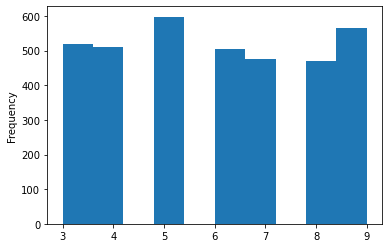

In [11]:
datamart['RFM_Score'].plot(kind='hist', bins=10)
plt.show()

In [12]:
# Define rfm_level function
def rfm_level(df):
    if df['RFM_Score'] >= 10:
        return 'Top'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 10)):
        return 'Middle'
    else:
        return 'Low'

# Create a new variable RFM_Level
datamart['RFM_Level'] = datamart.apply(rfm_level, axis=1)

# Print the header with top 5 rows to the console
print(datamart.head())


            Recency  Frequency  MonetaryValue  R  F  M  RFM_Score RFM_Level
CustomerID                                                                 
12747             3         25         948.70  3  3  3        9.0    Middle
12748             1        888        7046.16  3  3  3        9.0    Middle
12749             4         37         813.45  3  3  3        9.0    Middle
12820             4         17         268.02  3  3  3        9.0    Middle
12822            71          9         146.15  2  2  2        6.0    Middle


In [13]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = datamart.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
  
  	# Return the size of each segment
    'MonetaryValue': ['mean', 'count']
}).round(1)

# Print the aggregated dataset
print(rfm_level_agg)

          Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Level                                      
Low         153.4       4.4          86.9  1627
Middle       39.6      30.2         599.7  2016


## Prep for ch3
Notice the scale in the lab changes to 1 to 4, not 1 to 3. So let's recalculate and save as a csv

In [15]:
# Create labels for Recency and Frequency
r_labels = range(4, 0, -1); f_labels = range(1, 5)

# Assign these labels to three equal percentile groups 
r_groups = pd.qcut(datamart['Recency'], q=4, labels=r_labels)

# Assign these labels to three equal percentile groups 
f_groups = pd.qcut(datamart['Frequency'], q=4, labels=f_labels)

# Create new columns R and F 
datamart = datamart.assign(R=r_groups.values, F=f_groups.values)

# Create labels for MonetaryValue
m_labels = range(1, 5)

# Assign these labels to three equal percentile groups 
m_groups = pd.qcut(datamart['MonetaryValue'], q=4, labels=m_labels)

# Create new column M
datamart = datamart.assign(M=m_groups.values)

# Calculate RFM_Score
datamart['RFM_Score'] = datamart[['R','F','M']].sum(axis=1)
print(datamart['RFM_Score'].head())

# Define rfm_level function
def rfm_level(df):
    if df['RFM_Score'] >= 10:
        return 'Top'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 10)):
        return 'Middle'
    else:
        return 'Low'

# Create a new variable RFM_Level
datamart['RFM_Level'] = datamart.apply(rfm_level, axis=1)

# Print the header with top 5 rows to the console
print(datamart.head())

# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = datamart.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
  
  	# Return the size of each segment
    'MonetaryValue': ['mean', 'count']
}).round(1)

# Print the aggregated dataset
print(rfm_level_agg)

CustomerID
12747    12.0
12748    12.0
12749    12.0
12820    10.0
12822     7.0
Name: RFM_Score, dtype: float64
            Recency  Frequency  MonetaryValue  R  F  M  RFM_Score RFM_Level
CustomerID                                                                 
12747             3         25         948.70  4  4  4       12.0       Top
12748             1        888        7046.16  4  4  4       12.0       Top
12749             4         37         813.45  4  4  4       12.0       Top
12820             4         17         268.02  4  3  3       10.0       Top
12822            71          9         146.15  2  2  3        7.0    Middle
          Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Level                                      
Low         180.8       3.2          52.7  1075
Middle       73.9      10.7         202.9  1547
Top          20.3      47.1         959.7  1021


In [16]:
# actually - no need - it's already available as a csv file in the chapter3 data set